# HMM model knowledge
Blog: <https://blog.csdn.net/ebzxw/article/details/80465399>

## 输入输出
- 输入：
    - 隐藏状态数目
    - 输入的观测变量
    - 混合高斯分布成分数目
- 输出：
    - 每个时刻对应的状态序列
    - 混合分布的均值和方差矩阵
    - 混合分布的权重矩阵
    - 状态间转移概率矩阵

**HMM模型只是能分离出不同的状态，具体对每个状态赋予现实的市场意义，是需要人为来辨别和观察的。**


# Read data and procecss

In [5]:
from hmmlearn.hmm import GMMHMM, GaussianHMM
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import cm
from matplotlib import pyplot
import matplotlib.pyplot as plt

In [60]:
# Read data
data_test = pd.read_csv('../data/SSE_test.csv')
# 状态数量
n = 6

volume = data_test['vol']
close = data_test['close']

# 对数差分
# Delta = np.array(data['high']) - np.array(data['low'])

# 当日对数高地价差
logDel = np.log(np.array(data_test['high'])) - np.log(np.array(data_test['low']))
# 当日对数收益率
logRet_1 = np.array(np.diff(np.log(close)))
# 5日对数收益率
logRet_5 = np.log(np.array(close[5:])) - np.log(np.array(close[:-5]))
# 5日对数成交量
logVol_5 = np.log(np.array(volume[5:])) - np.log(np.array(volume[:-5]))

# 保持所有的数据shape相同
logDel = logDel[5:]
logRet_1 = logRet_1[4:]
close = close[5:]

#将行数合并
data_test['date_time'] = pd.to_datetime(data_test['trade_date'], format='%Y%m%d')
Date = pd.to_datetime(data_test['date_time'][5:])

A_test = np.column_stack([logDel, logRet_5, logVol_5])
A_test.shape

(723, 3)

In [58]:
# Read data
data = pd.read_csv('../data/SSE.csv')
# 状态数量
n = 6

volume = data['vol']
close = data['close']

# 对数差分
# Delta = np.array(data['high']) - np.array(data['low'])

# 当日对数高地价差
logDel = np.log(np.array(data['high'])) - np.log(np.array(data['low']))
# 当日对数收益率
logRet_1 = np.array(np.diff(np.log(close)))
# 5日对数收益率
logRet_5 = np.log(np.array(close[5:])) - np.log(np.array(close[:-5]))
# 5日对数成交量
logVol_5 = np.log(np.array(volume[5:])) - np.log(np.array(volume[:-5]))

# 保持所有的数据shape相同
logDel = logDel[5:]
logRet_1 = logRet_1[4:]
close = close[5:]

#将行数合并
data['date_time'] = pd.to_datetime(data['trade_date'], format='%Y%m%d')
Date = pd.to_datetime(data['date_time'][5:])

A = np.column_stack([logDel, logRet_5, logVol_5])
A.shape

(2426, 3)

# HMM model

/home/zuohaolan/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


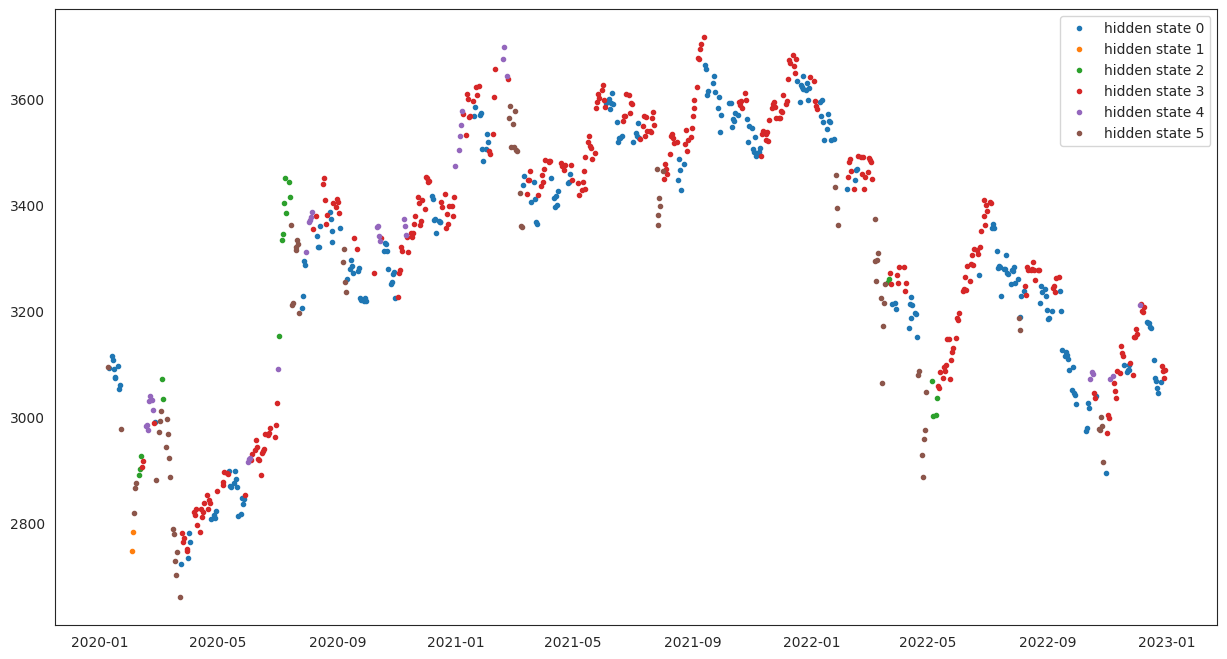

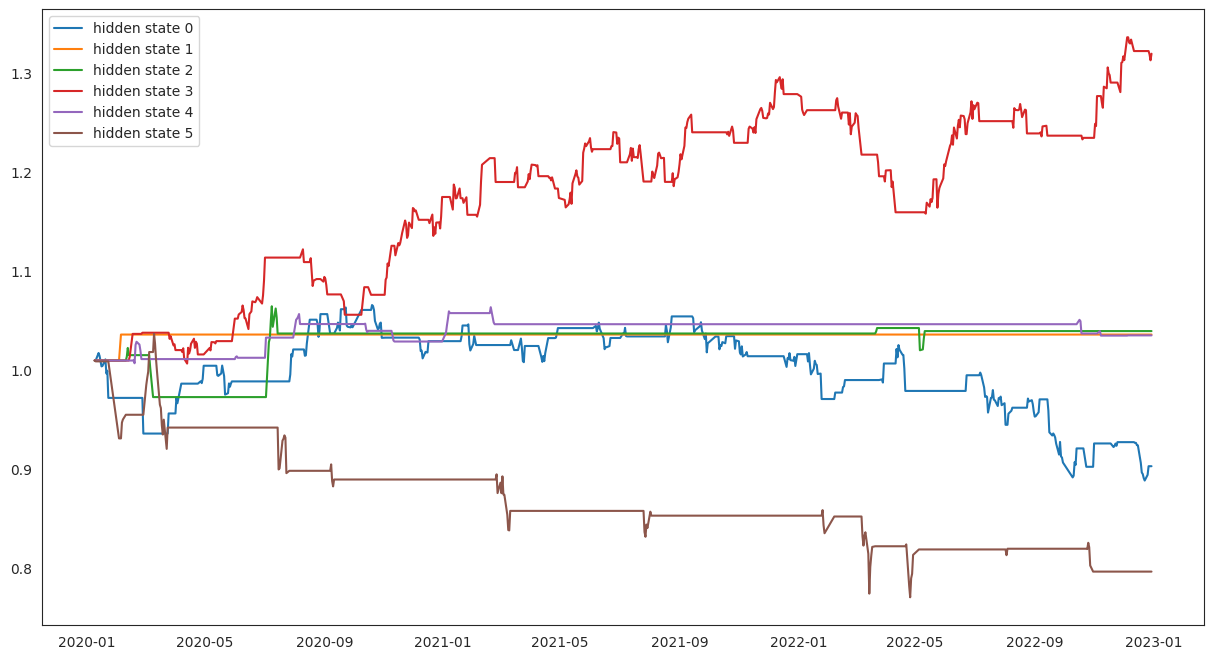

In [61]:
# Train the HMM
model = GaussianHMM(n_components=n, covariance_type="diag", n_iter=2000).fit(A)

# Predict
hidden_states = model.predict(A_test)


plt.figure(figsize=(15, 8))
for i in range(n):
    pos = (hidden_states == i)
    plt.plot_date(Date[pos], close[pos], '.', label='hidden state %d' % i, lw=2)
    plt.legend()
plt.show()

res = pd.DataFrame({'Date': Date, 'logReg_1': logRet_1, 'state': hidden_states}).set_index('Date')
series = res.logReg_1

templist = []
plt.figure(figsize=(15, 8))
for i in range(n):
    pos = (hidden_states == i)
    pos = np.append(1, pos[:-1])
    res['state_ret%d' % i] = series.multiply(pos)
    data_i = np.exp(res['state_ret%d' % i].cumsum())
    templist.append(data_i[-1])
    plt.plot_date(Date, data_i, '-', label='hidden state %d' % i)
    plt.legend()
plt.show()

# Backtest

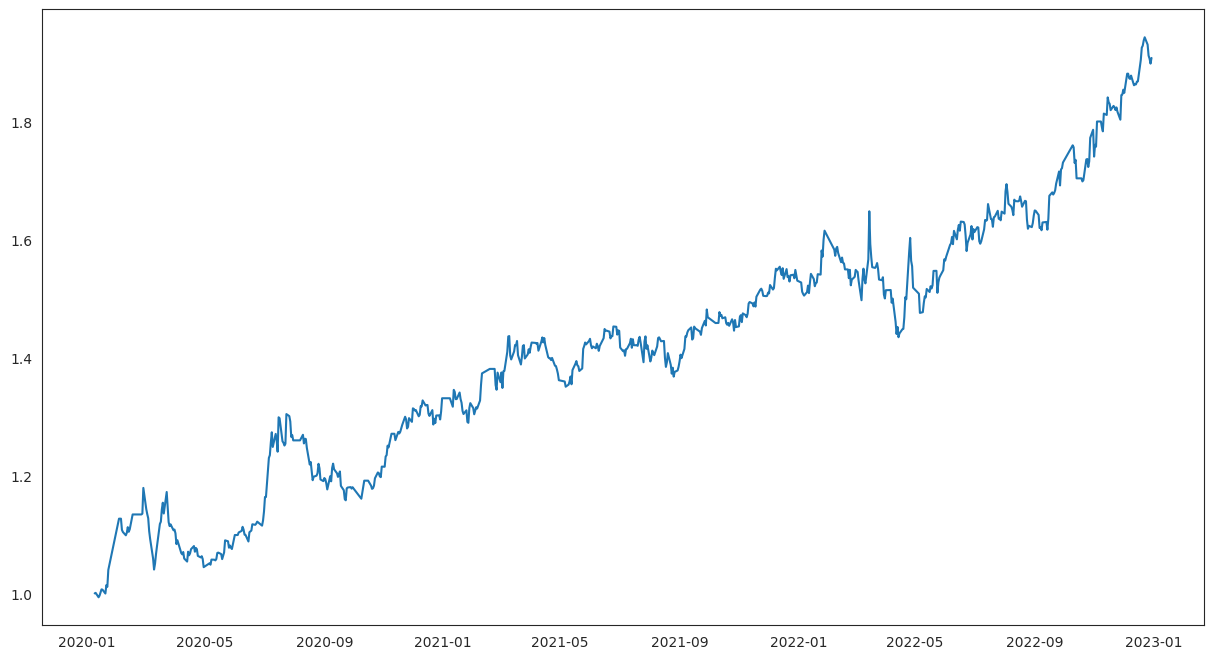

In [62]:
templist = np.array(templist).argsort()
long = (hidden_states == templist[-1]) + (hidden_states == templist[-2])  # 买入
short = (hidden_states == templist[0]) + (hidden_states == templist[1])  # 卖出
long = np.append(0, long[:-1])
short = np.append(0, short[:-1])

plt.figure(figsize=(15, 8))
res['ret'] = series.multiply(long) - series.multiply(short)
plt.plot_date(Date, np.exp(res['ret'].cumsum()), '-')
plt.show()